In [ ]:
# Данная работа посвященна анализа изменения стоимости акций компании 'Coca Cola'  
# на продолжительном периоде наблюдения (1962 - 1921 гг). Компания 'Coca Cola' является 
# крупной международной компанией, работющей по всему миру на огромном рынке продуктов питания.
# В связи с этим стоимость ее акций должна быть достаточно стабильной и реагировать значительно 
# только на глобальные изменения мировой экономики и отражать общие тенденции развития мирового
# рынка продовольствия. При построении достаточно точной модели изменения стоимости акций компании
# необходимо оценить возможность прогнозирования их стоимости на некотторый период времени,
# который зависит от общей  ситуации в мировой экономике ( неожиданный катаклизм практически 
# устраняет возможность какого -либо разумного прогнозирования). В результате анализа тенденций
# изменения стоимости акций и возможности ее прогнозирования предлагается попробовать оценить
# минимальный разумный период учета данных для построения модели оценки стоимости акций в целях 
# приминения для прогноза текущей стоимости акций

In [ ]:
# Задачи:
# - Провести анализ динамика изменения стоимости акций
# - Определить факторы, влияющие на изменение динамики изменения стоимости акций.
#       (выделить временные интервалы 'резких изменений тенденция' и попытаться найти причину
#        в изменениях мировой коньюктуры рынка)
# - Построить модели оценки изменения стоимости акций с учетом всего представленного периода
#        развития экономической ситуации
# - Провести оценку качества прогнозов, получаемых с помощью построенных моделей

In [ ]:
# Подготовительный период ( загружаем необходимый набор библиотек исходя из планируемых методов
# анализа данных и построения моделей прогнозирования)

In [1]:
import numpy as np 
import pandas as pd 
from pandas import DataFrame
import matplotlib.pyplot as plt

# библиотеки для построения моделей
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose      
from pmdarima import auto_arima                              
from statsmodels.tsa.ar_model import AR

# метрики
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse

# для игнорирования предупреждений
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Загружаем данные ( предварительно файл с данными размещен на локальном компьютере)
import pandas as pd
df = pd.read_csv('COCO COLA.csv', index_col='Date', parse_dates=['Date'])
# сразу распознаем данные Date и изменяем дискретность данных на ежемесячные средние
# посмотрим на исходные данные для 'визуальной проверки достоверности загруженных данных'
df = df.resample('M').mean()
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-31,0.248432,0.250784,0.245221,0.247692,0.048153,1.337018e+06
1962-02-28,0.243695,0.245546,0.241982,0.243318,0.047303,6.952421e+05
1962-03-31,0.245531,0.247203,0.244126,0.245517,0.047930,1.939200e+06
1962-04-30,0.248340,0.250618,0.245866,0.248047,0.048535,1.023360e+06
1962-05-31,0.232762,0.234982,0.227939,0.231564,0.045310,2.234182e+06


In [3]:
# проверяем правильность распознавания типов данных при загрузке 
# (т.к. в датасете средние ежемесячные значения, то все числовые значения получили тип float)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 1962-01-31 to 2021-12-31
Freq: M
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       720 non-null    float64
 1   High       720 non-null    float64
 2   Low        720 non-null    float64
 3   Close      720 non-null    float64
 4   Adj Close  720 non-null    float64
 5   Volume     720 non-null    float64
dtypes: float64(6)
memory usage: 39.4 KB


In [4]:
# Если внимально изучить вышеуказанные сведения о датасете, то видно что в нем отсутствуют 
# пустые строки ( всего 720 строк и для каждой колонки 720 ненулевых данных)
# Проверим наличие пропусков данных в загруженном датасете
# и убедимся что данные не требуют очистки
df.isnull()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-31,False,False,False,False,False,False
1962-02-28,False,False,False,False,False,False
1962-03-31,False,False,False,False,False,False
1962-04-30,False,False,False,False,False,False
1962-05-31,False,False,False,False,False,False
...,...,...,...,...,...,...
2021-08-31,False,False,False,False,False,False
2021-09-30,False,False,False,False,False,False
2021-10-31,False,False,False,False,False,False


In [5]:
# Получим общестатистические данные о полученном датасете 
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,720.000000,720.000000,720.000000,720.000000,720.000000,7.200000e+02
mean,16.067735,16.200015,15.933392,16.072319,11.384551,9.029490e+06
std,16.961081,17.086733,16.832736,16.962937,14.287341,6.534544e+06
min,0.204241,0.206814,0.200986,0.203233,0.039972,4.468364e+05
25%,0.862740,0.868096,0.855472,0.861998,0.241078,3.170400e+06
50%,9.479336,9.592989,9.386972,9.501573,4.717325,8.711218e+06
75%,28.987626,29.382500,28.741837,29.052066,17.316536,1.334197e+07
max,58.793158,59.192105,58.301053,58.652632,55.782308,4.038423e+07


In [ ]:
# Из полученных данных можно сделать отдельные наблюдения:
# - большой разброс объемов торгов ( 446 0000 - 40 000 000)
# - наличие большой разницы средних значений Close и Adj Close
# - ( что указывает на наличие существенных влияний корпоративных мероприятий компании на 
#     стоимость акций на большом периоде времени)

In [ ]:
# Adj Close Это ценовой ряд, который отражает дивиденды, дробление акций
# и другие корпоративные события, которые влияют на доходность акций.
# Наличие существенных событий из этого набора может сильно влиять на доходность
# акций. Соответственно наличие существенных отличий значений Close и Adj Close свидетельствут
# о присутствии активной дивидентной политики, дроблений или эмиссий новых пакетов акций.
# Попробуем проследить как значения Adj Close коррелируют со стоимостью акций и объемам  торгов

In [6]:
# добавим в датасет столбец со значения разницы между Close и Close Adj
df['Adj']= abs(df.loc[:,'Close']-df.loc[:,'Adj Close'])
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume,Adj
Date,,,,,,,
2021-03-31,51.131739,51.692609,50.814348,51.280000,49.966713,1.966035e+07,1.313287
2021-04-30,53.568572,53.890953,53.281429,53.589524,52.384100,1.289560e+07,1.205424
2021-05-31,54.597000,54.894000,54.263000,54.600000,53.371847,1.549516e+07,1.228153
2021-06-30,55.091818,55.302727,54.761363,55.010455,54.010215,1.390262e+07,1.000240
2021-07-31,55.660000,56.005714,55.365714,55.726667,54.883626,1.397073e+07,0.843041
2021-08-31,56.620000,56.835000,56.322727,56.556818,55.701219,1.001493e+07,0.855599
2021-09-30,55.070476,55.367619,54.660000,54.906190,54.324465,1.592811e+07,0.581725
2021-10-31,54.252381,54.582857,53.984762,54.320953,53.902945,1.580040e+07,0.418008
2021-11-30,55.917143,56.161429,55.505238,55.796191,55.386051,1.365144e+07,0.410140


<AxesSubplot:title={'center':' стоимость закрытия'}, xlabel='Date'>

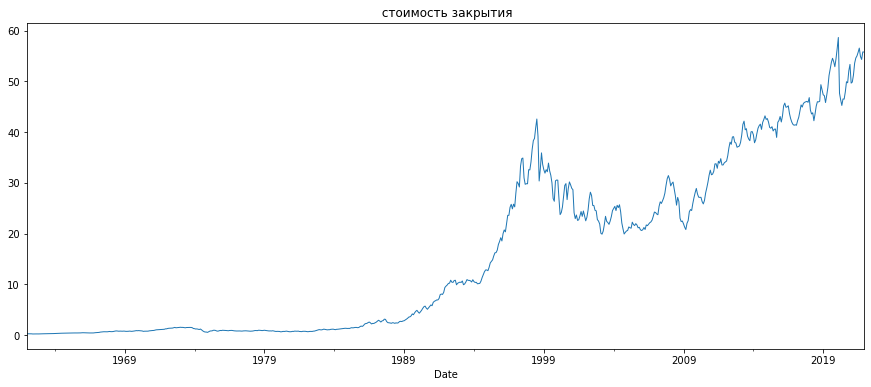

In [7]:
# Выберем в качестве метрики для прогнозирования стоимость закрытия Close (стоимость акции
# на конец торгового дня)
# Для отображения общей картины изменения стоимости акций построим график цены закрытия Close
df['Close'].plot(figsize=(15,6), linewidth =1.0, title =' стоимость закрытия')

In [119]:
# На графике видно что примерно в 1991 г. начинается стремительный рост стоимости акций
# ( возможно связано с началом активного вывода средств из бывшего СССР и начало бурного
# роста финансового рынка ( рост спекулятивного капитала), затем обвал стоимости в 1998 году
# ( экономический кризис)
# затем наблюдался период стабилизации ( примерно до 2008г), затем опять обвал стоимости
# ( кризис 2008 года) и затем плавный рост стоимости акций
# В начале 2020 г. наблюдается резкий обвал стоимости акций ( начало ковид-пандемии)

In [ ]:
# Проанализируем визуально исходные данные по следующим вопросам:
# - Взаимосвязь между стоимостью акций и объемами торгов
# - взаимосвязь между стоимостью акций и корректирокой стоимости акций 
#  (связанной с корпоративными событиями и возможно какими то другими параметрами)
#   для визуального анализа построим графики значений параметров 'Close','Volume', 'Adj'

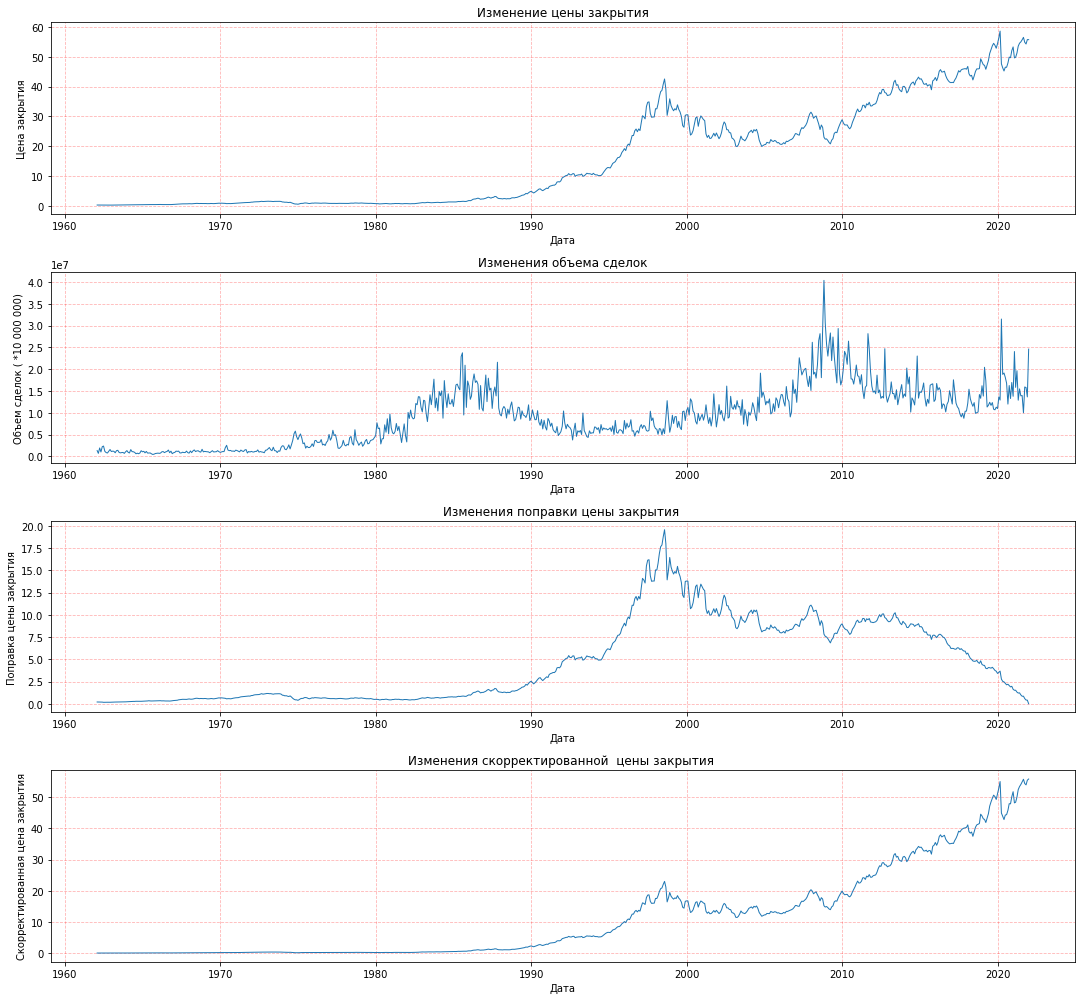

In [8]:

x = df.index
y1 = df['Close']
y2 = df['Volume']
y3 = df['Adj']
y4 = df['Adj Close']

fig = plt.figure(num = "fig1",figsize=(15,14),edgecolor='green')

ax1 = fig.add_subplot(4,1,1)
ax1.plot(x, y1, linewidth = 1.0)
ax1.grid(color='r', linestyle='--',alpha=0.3)
ax1.set_xlabel('Дата')
ax1.set_ylabel('Цена закрытия')
ax1.set_title('Изменение цены закрытия')

ax2 = fig.add_subplot(4,1,2)
ax2.plot(x, y2, linewidth = 1.0)
ax2.grid(color='r', linestyle='--',alpha=0.3)
ax2.set_xlabel('Дата')
ax2.set_ylabel('Объем сделок ( *10 000 000)')
ax2.set_title('Изменения объема сделок')

ax3 = fig.add_subplot(4,1,3)
ax3.plot(x, y3, linewidth = 1.0)
ax3.grid(color='r', linestyle='--',alpha=0.3)
ax3.set_xlabel('Дата')
ax3.set_ylabel('Поправка цены закрытия')
ax3.set_title('Изменения поправки цены закрытия ')

ax4 = fig.add_subplot(4,1,4)
ax4.plot(x, y4, linewidth = 1.0)
ax4.grid(color='r', linestyle='--',alpha=0.3)
ax4.set_xlabel('Дата')
ax4.set_ylabel('Скорректированная цена закрытия')
ax4.set_title('Изменения скорректированной  цены закрытия ')

plt.tight_layout()



In [ ]:
# Из полученных графиков можно сделать следующие предположения:
# - начиная с 1982 г. объем торговли акциями находится  в среднем около 10 млн акций/месяц
# - величина поправки стоимости акции была относительно стабильна и начала увеличиваться
#   с моменты начала быстрого роста в 1991г. Возможно это было связано с нарастанием финансовых
#   спекуляций ( стремительный рост акций). Пик поправок пришел на начало кризиса 1998г.Затем,
#   по всей видимости, произошла корректировка корпоративных процедур и постепенно к настоящему
#   времени поправка стоимости акций ( из-за корпоративных процедур) была приведена фактически 
#   к нулю и сейчас стоимость акций на момент закрытия дня совпадает со скорректированой
#   стоимостью акций. Т.е. в настоящее время корпоративные процедуры не влияют на стоимость
#   акций ( доходность акций)

array([[<AxesSubplot:title={'center':'Close'}>,
        <AxesSubplot:title={'center':'Volume'}>]], dtype=object)

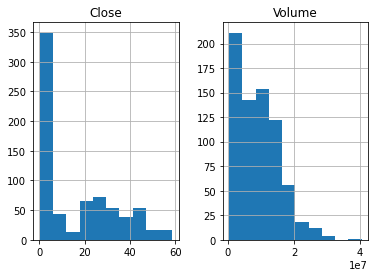

In [9]:
# Изучим гистограммы для Close и Volume с целью определения возможных особенностей
# будующей модели
df[['Close','Volume']].hist()

In [ ]:
# На гистограмах видно что среди значений стоимости акций преобладают значения из диапазона
# ( 0.2 - 10.0). Соответственно возможно предположить что в создаваемой модели оценки стоимости
# акций может быть небольшим понижающий эффект ( на текущий момент стоимость достигает 60 единиц)

In [ ]:
# Построим график изменения цены закрытия и график скользящей средней с окном 5.
# Скользящее среднее позволяет лучше увидеть тренд движения стоимости акций
# Скользящее среднее на текущем интервале может использоваться для принятия решений купить/продать

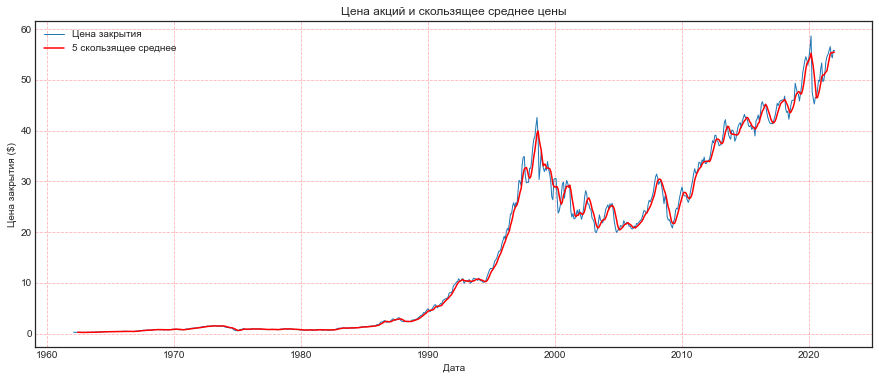

In [10]:
Aver5 = df['Close'].rolling(window=5).mean()
plt.style.use('seaborn-white')

plt.figure(figsize = (15,6))
plt.plot(df['Close'], label='Цена закрытия', linewidth = 1)
plt.plot(Aver5, label='5 скользящее среднее', linewidth = 1.5, color ='r')
plt.grid(color='r', linestyle='--',alpha=0.3)
plt.xlabel('Дата')
plt.ylabel('Цена закрытия ($)')
plt.title('Цена акций и скользящее среднее цены')
plt.legend()
plt.show()

In [ ]:
# Выводы вводной части:
# - Полученные данные являются качественным набором данных без пропусков и пустых значений
# - метрикой для построения модели прогнозирования стоимости акций выбирается цена закрытия Close
#   т.к. значения Open, High, Low привыбранной дискретности представления данных близки 
#   значению Close и повторяют динамику значений Close. Параметр Adj Close. который считается
#   существенным с точки зрения оценки доходности акций, стремится к нулю и  практически
#   совпадает с параметром Close  на последнем временном интервале представленных данных

# Построение моделей

In [183]:
# Для предварительной оценки параметров модели произведем декомпозицию временного ряда 
# (для параметра - Close)


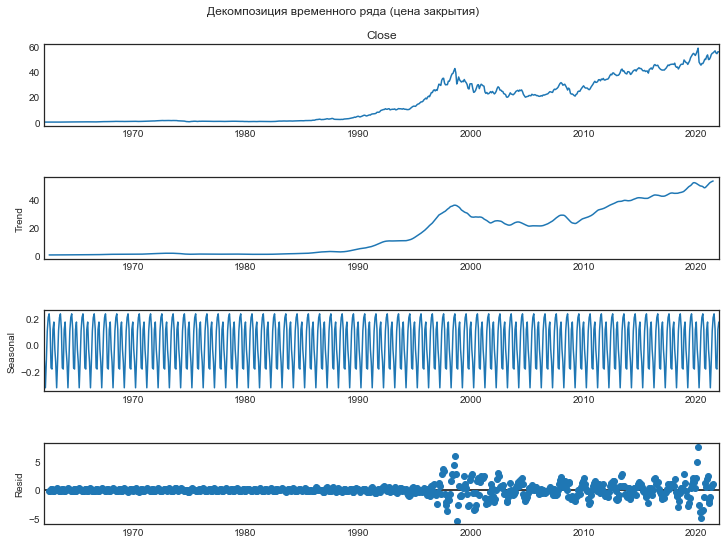

In [11]:
# Построим аддитивную модель разложения временного ряда
decomposition = seasonal_decompose(df['Close'], model='additive')

fig = decomposition.plot()
fig.set_figwidth(11)
fig.set_figheight(8)
fig.suptitle('Декомпозиция временного ряда (цена закрытия)')
plt.show()

In [ ]:
# При декомпозиции наблюдается явный тренд в изменении параметра Close
# Также присутствует сезонность.Период сезонности  период явно не определен.
# Его будем определять при вычислении параметров модели

In [ ]:
Задачи данного этапа:

- описать модель
- подобрать оптимальные параметры 
    c помощью метода ARIMA, необходимо достичь учета сезонности ( на его наличие
                                                                 указывает декомпозиция)
- создать модель
    с помощью метода SARIMAX
    с помощью метода AR
Далее для каждой модели
- обучить модель
    на наборе обучающих данных (набор train)
- сделать прогноз на период тестовой выборки
    с помощью обученной модели на период равный размерй тестовой выборки (набор test)
- сравнить прогноз с тестовой выборкой (построить график)
- оценить качество прогноза
    с помощью MSE ( средняя квадратическая ошибка) и RMSE ( среднеквадратическая ошибка)
- сделать прогноз на определеный позднее период
    будем ориентироваться на определенный при построении модели период сезонности
- сделать выводы о работе данного метода прогнозирования
    

### ПОСТРОЕНИЕ МОДЕЛИ С ИСПОЛЬЗОВАНИЕМ SARIMAX

In [12]:
# С использованием метода ARIMA подберем параметры нашей модели
# Для определения сезонности в нашей модели был произведен подбор параметров модели
# с разными величинами m ( величина сезонности). 
# В результате было определено что оптимальным является  сезонность  m = 8 (8 месяцев))
auto_arima(df['Close'], seasonal = True, m = 8).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  720
Model:             SARIMAX(0, 1, 3)x(2, 0, [1], 8)   Log Likelihood                -998.699
Date:                             Thu, 24 Mar 2022   AIC                           2013.399
Time:                                     22:08:14   BIC                           2050.022
Sample:                                          0   HQIC                          2027.538
                                             - 720                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1247      0.062      2.016      0.044       0.003       0.246
ma.L1          0.1803      0.020      9.112      0.000       0.142       0.219
ma.L2         -0.0990      0.025     -3.987      0.000      -0.148      -0.050
ma.L3         -0.0887      0.024     -3.690      0.000      -0.136      -0.042
ar.S.L8       -0.4861      0.191     -2.538      0.011      -0.861      -0.111
ar.S.L16      -0.1582      0.026     -6.041      0.000      -0.210      -0.107
ma.S.L8        0.4276      0.197      2.174      0.030       0.042       0.813
sigma2         0.9412      0.023     41.548      0.000       0.897       0.986
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             22032.69
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             181.23   Skew:                            -2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
Получилась модель с параметрами SARIMAX(0, 1, 3)x(2, 0, [1], 8)

In [ ]:
# Разделим исходный набор данных на обучающий и тестовый ( дикретность соответствует периодичности)

In [13]:
train = df.iloc[:len(df)-8]
test = df.iloc[len(df)-8:]


In [14]:
# создаем модель с подобранными параметрами
model = SARIMAX(train['Close'],order=(0, 1, 3), seasonal_order = (2,0,[1],8))
#обучаем модель на обучающей выборке данных
results = model.fit()

#получаем результаты
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                  712
Model:             SARIMAX(0, 1, 3)x(2, 0, [1], 8)   Log Likelihood                -989.250
Date:                             Thu, 24 Mar 2022   AIC                           1992.500
Time:                                     22:09:24   BIC                           2024.467
Sample:                                 01-31-1962   HQIC                          2004.848
                                      - 04-30-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1923      0.020      9.833      0.000       0.154       0.231
ma.L2         -0.0867      0.025     -3.461      0.001      -0.136      -0.038
ma.L3         -0.0822      0.024     -3.422      0.001      -0.129      -0.035
ar.S.L8       -0.4430      0.177     -2.504      0.012      -0.790      -0.096
ar.S.L16      -0.1790      0.026     -6.876      0.000      -0.230      -0.128
ma.S.L8        0.3766      0.182      2.066      0.039       0.019       0.734
sigma2         0.9455      0.023     40.772      0.000       0.900       0.991
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):             22002.19
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):             937.56   Skew:                            -2.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
#предсказываем значения,передав модели results точку начала и окончания
start = len(train)
end = len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename(' Predictions SARIMAX(0, 1, 3)x(2, 0, [1], 8)')

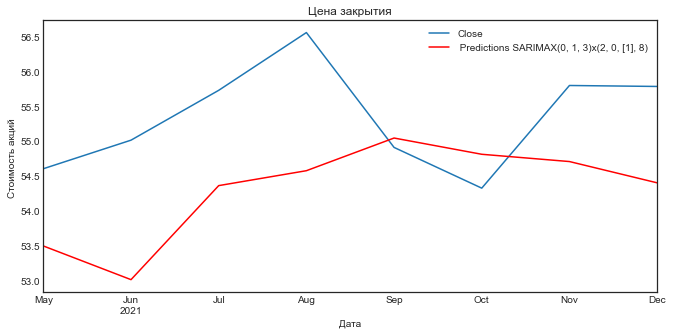

In [16]:
ax = test['Close'].plot(legend = True, figsize = (11,5)) # График известных тестовых значений
predictions.plot(legend = True, color = 'r') # График прогнозируемых ( в соответствии с моделью) значений
ax.set_title( 'Цена закрытия')
ax.set_xlabel('Дата')
ax.set_ylabel('Стоимость акций ')
ax.autoscale(axis = 'x', tight = True)

###  Оцениваем качество модели с помощью MSE, RMSE, MAPE, MAE 


In [17]:
# оценка модели методами MSE и RMSE
mse_value = mean_squared_error(test['Close'], predictions)
rmse_value = rmse(test['Close'], predictions)
mape_value = np.mean(np.abs(predictions - test['Close'])/test['Close'])*100
mae_value = mean_absolute_error(test['Close'], predictions)

print(f'SARIMAX(0, 1, 3)x(2, 0, [1], 8) MSE Error: {mse_value:11.10}')
print(f'SARIMAX(0, 1, 3)x(2, 0, [1], 8) RMSE Error: {rmse_value:11.10}')
print(f'SARIMAX(0, 1, 3)x(2, 0, [1], 8) MAPE Error: {mape_value:11.10}')
print(f'SARIMAX(0, 1, 3)x(2, 0, [1], 8) MAE Error: {mae_value:11.10}')

SARIMAX(0, 1, 3)x(2, 0, [1], 8) MSE Error: 1.804042525
SARIMAX(0, 1, 3)x(2, 0, [1], 8) RMSE Error: 1.343146502
SARIMAX(0, 1, 3)x(2, 0, [1], 8) MAPE Error:   2.1533203
SARIMAX(0, 1, 3)x(2, 0, [1], 8) MAE Error: 1.196008151


In [143]:
# с учетом величины RMSE ( ошибки модели) будет считать качество модели удовлетворительным

###  Тренировка модели на всем датасете и прогнозирование на год вперед

In [18]:
model_full = SARIMAX(df['Close'],order = (0,1,3), seasonal_order = (1,0,[1],8))
results_full = model.fit()
results_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                  712
Model:             SARIMAX(0, 1, 3)x(2, 0, [1], 8)   Log Likelihood                -989.250
Date:                             Thu, 24 Mar 2022   AIC                           1992.500
Time:                                     22:09:40   BIC                           2024.467
Sample:                                 01-31-1962   HQIC                          2004.848
                                      - 04-30-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1923      0.020      9.833      0.000       0.154       0.231
ma.L2         -0.0867      0.025     -3.461      0.001      -0.136      -0.038
ma.L3         -0.0822      0.024     -3.422      0.001      -0.129      -0.035
ar.S.L8       -0.4430      0.177     -2.504      0.012      -0.790      -0.096
ar.S.L16      -0.1790      0.026     -6.876      0.000      -0.230      -0.128
ma.S.L8        0.3766      0.182      2.066      0.039       0.019       0.734
sigma2         0.9455      0.023     40.772      0.000       0.900       0.991
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):             22002.19
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):             937.56   Skew:                            -2.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
#строим прогноз на год вперед
forecast = results_full.predict(start=len(df)-1, end=len(df)+11,typ='levels').rename('SARIMAX(0, 1, 3)x(2, 0, [1], 8)Forecast')


###  Постройте график предсказаний и график исходных данных

Text(0, 0.5, 'Стоимость акций')

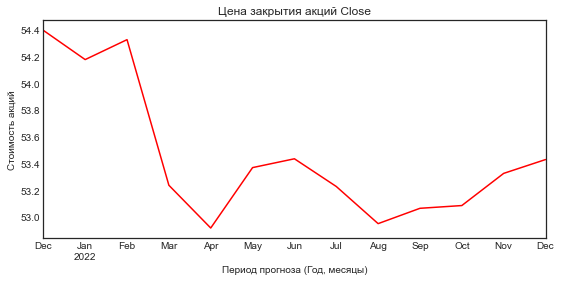

In [20]:
ax = forecast.plot(figsize = (9,4), color = 'r')
ax.set_title('Цена закрытия акций Close')
ax.set_xlabel('Период прогноза (Год, месяцы)')
ax.set_ylabel('Стоимость акций')

In [148]:
# Прогнозная модель 'адекватно' отображает периодичность исходных данных на интервале год
# для визуализации 'соответствия стат характеристик  прогнозной модели исходному набору данных
# построим общий график ( исходные данные плюс период прогноза)

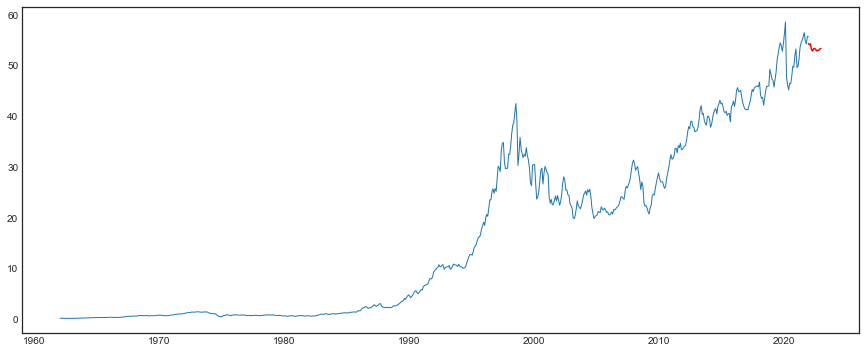

In [23]:
#Строим совместный график существующей выборки и прогноза на год вперед ( для визуальной оценки
# качества построенной модели )
plt.figure(figsize = (15,6))
plt.plot(df['Close'], label='Цена закрытия', linewidth = 1)
plt.plot(forecast, color = 'r')


In [ ]:
# На общем графике, при сохранении тенденции изменения параметра Close, заметно некоторое 
# 'понижение' прогнозного графика ( предположение о таком эффекте было сделано ранее)
# Проверим как будет происходить 'стыковка' прогноза с графиком построенным моделью по всему
# исходному набору

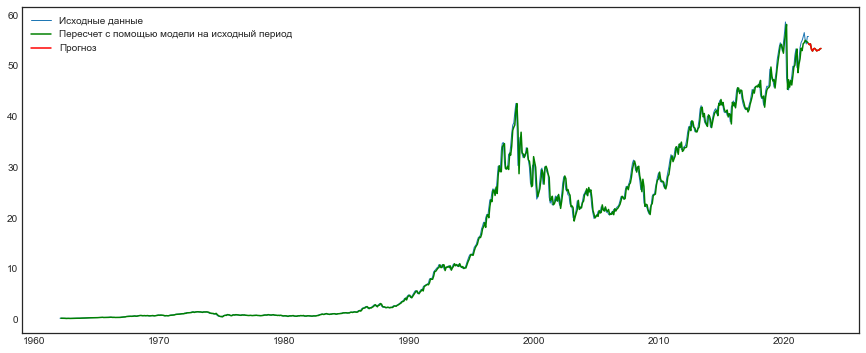

In [24]:
forecastB = results_full.predict(start=1, end=len(df)+11,typ='levels').rename('SARIMAX(0, 1, 3)x(2, 0, [1], 8)Forecast')
plt.figure(figsize = (15,6))
plt.plot(df['Close'], label='Исходные данные', linewidth = 1)
plt.plot(forecastB, label='Пересчет с помощью модели на исходный период', linewidth = 1.5, color ='g')
plt.plot(forecast, color = 'r', label = 'Прогноз')
plt.legend()
plt.show()

In [ ]:
# На данном графие пересчитанный график значений Close с использованием созданной модели 
# на исходном интервале времени 'точно' переходит в прогнозный график. График исходных данных
# немного выше. ( т.е. наблюдается 'проседание' данных модели). Возможно это связано с большим 
# интервалом относительно малых значений Close без явной тенденции к росту.
# если применить модель на более коротком интервале ( например период 2010 ...), то вероятно
# модель прогноза будет более точной

In [150]:
# Из полученного графика возможно сделать заключение о том что полученная модель в достаточной
# мере отражает основные статистические характеристики набора данных ( тренд, сезонность)

### ПОСТРОЕНИЕ МОДЕЛИ С ИСПОЛЬЗОВАНИЕМ AR

In [25]:
# разбиение исходного датасета на train_l и test_l
df_ar = df['Close']
train_l, test_l = df_ar[1:len(df_ar)-8], df_ar[len(df_ar)-8:]

In [27]:
# построение модели авторегрессии ( в автоматическом режиме)
model_l = AR(train_l)
model_fit_l = model_l.fit()
print('Lag: %s' % model_fit_l.k_ar) # Глубина авторегрессии
print('Coefficients: %s' % model_fit_l.params) # Коэффициенты авторегрессии

Lag: 20
Coefficients: const        0.054510
L1.Close     1.197933
L2.Close    -0.354166
L3.Close     0.119545
L4.Close     0.080201
L5.Close    -0.111621
L6.Close     0.037440
L7.Close     0.045686
L8.Close    -0.098356
L9.Close     0.000973
L10.Close    0.140954
L11.Close   -0.157394
L12.Close    0.210433
L13.Close   -0.013231
L14.Close   -0.219610
L15.Close    0.253527
L16.Close   -0.343993
L17.Close    0.378890
L18.Close   -0.117847
L19.Close   -0.059390
L20.Close    0.011713
dtype: float64


In [28]:
# построение прогноза на основе созданной модели для сравнения с тестовым набором
predictions_l = model_fit_l.predict(start=len(train_l), end=len(train_l)+len(test_l)-1, dynamic=False)
for i in range(len(predictions_l)):
	print('predicted=%f, expected=%f' % (predictions_l[i], test_l[i]))

predicted=54.395916, expected=54.600000
predicted=53.183484, expected=55.010455
predicted=55.705213, expected=55.726667
predicted=54.336590, expected=56.556818
predicted=54.045222, expected=54.906190
predicted=53.819133, expected=54.320953
predicted=54.104830, expected=55.796191
predicted=54.648994, expected=55.782308


Test MSE: 1.681
Test RMSE: 1.297
Test MAPE: 1.902
Test MAE: 1.058


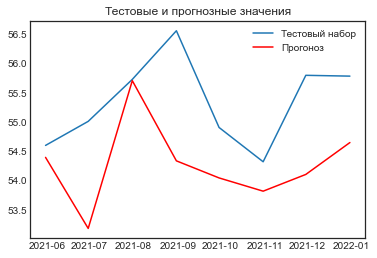

In [29]:
# Оценка точности модели
mse_value = mean_squared_error(test_l, predictions_l)
rmse_value = rmse(test_l, predictions_l)
mape_value = np.mean(np.abs(predictions_l - test_l)/test_l)*100
mae_value = mean_absolute_error(test_l, predictions_l)
print('Test MSE: %.3f' % mse_value)
print('Test RMSE: %.3f' % rmse_value)
print('Test MAPE: %.3f' % mape_value)
print('Test MAE: %.3f' % mae_value)

plt.plot(test_l, label = 'Тестовый набор')
plt.plot(predictions_l, label = 'Прогоноз', color='red')
plt.title('Тестовые и прогнозные значения')
plt.legend()
plt.show()

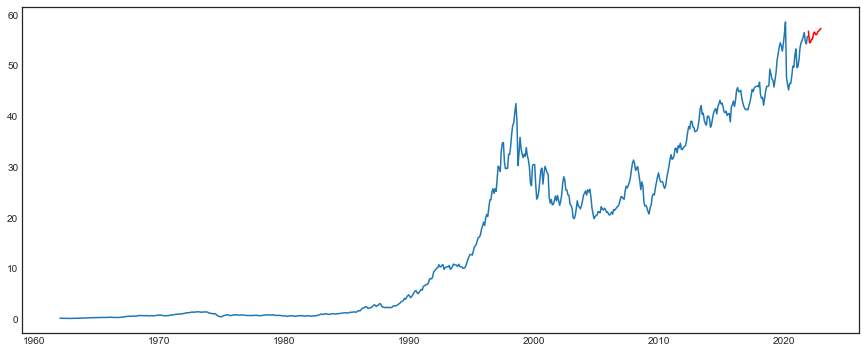

In [30]:
# Настроим модель AR на всем наборе исходных данных
model_all = AR(df_ar)
model_fit_all = model_all.fit()
#print('Lag: %s' % model_fit_all.k_ar)
#print('Coefficients: %s' % model_fit_all.params)
# Построим прогноз на год вперед
forecast_all = model_fit_all.predict(start=len(df_ar)-1, end=len(df_ar)+11, dynamic=False)
plt.figure(figsize =(15,6))
plt.plot(df_ar)
plt.plot(forecast_all, color='red')
plt.show()

In [ ]:
# На графике заметно что эффект 'проседания' прогноза, который наблюдался в предыдущей модели,
# отсутствует. Данный эффект вероятно объясняется тем, что в модели AR используются данные с
# лагом, вычисленным при построении модели ( здесь шаг 20) а не за весь период. В этом случае
# на прогноз не влияют  тенденции ранних периодов ( тенденции, которые отличаются от тендений
# ближайших к прогнозируему периоду)

In [ ]:
# Для визуализации отличий прогнозов двух моделей отобразим графики этих прогнозов
# На этих графиках явно заметен эффект 'проседания'

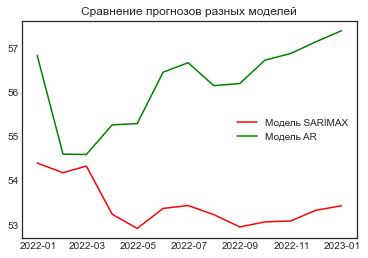

In [31]:

plt.plot(forecast, color = 'r', label = 'Модель SARIMAX')
plt.plot(forecast_all, color='g', label = 'Модель AR')
plt.title('Сравнение прогнозов разных моделей')
plt.legend()
plt.show()

In [33]:
# Сравнение точности моделей на тестовом наборе
# модель AR
#Test MSE: 1.681
#Test RMSE: 1.297
#Test MAPE: 1.902
#Test MAE: 1.058
# модель SARIMA  
#MSE Error: 1.804042525
#RMSE Error: 1.343146502
#MAPE Error:   2.1533203
#MAE Error: 1.196008151

In [ ]:
# Сравнение оценок точности полученных моделей показываем что для данного датасета
# модель AR немного точнее ( Что странно!!! )

### ЗАКЛЮЧЕНИЕ

In [ ]:
В настоящей работе проведен анализ данных с использованием современных методов обработки
статистической информации. 
Рассчитаны основные статистические метрики, позволяющие судить о характере исследуемого явления.
Анализ применения моделей показал степень влияния особенностей исходных данных на выбор метода
построения модели прогнозирования
Результат анализа представленных данных позволили сделать вывод о том, что для получения
адекватных моделей прогнозирования для рынка акций компаний необходимо убирать дальнюю историчность
данных, т.к. в течении нескольких лет общая экономическая ситуация и закономерности ее развития
заметно изменяются и данные дальних периодов вносят недостоверные, для текущего периода, тенденции
в модель, предназначенную для использования в текущем периоде.
Данный вывод базируется на т.н. плавности перехода от исходных данных к прогнозу и оценках 
точности построенных моделей.
Для использования рассмотренных методов прогнозирования в целях прогнозирования текущих стоимостей
акций необходимо определить ближайший период относительно стабильного периода развития рынка и 
строить модель на основе данных этого периода.



#### Дополнительно построим модель методом линейного тренда Хольта, Холта-Винтера

In [67]:
df_arr = df['Close']
train_2, test_2 = df_arr[1:len(df_arr)-8], df_arr[len(df_arr)-8:]



Test MSE: 1.648
Test RMSE: 1.284
Test MAPE: 2.208
Test MAE: 1.221


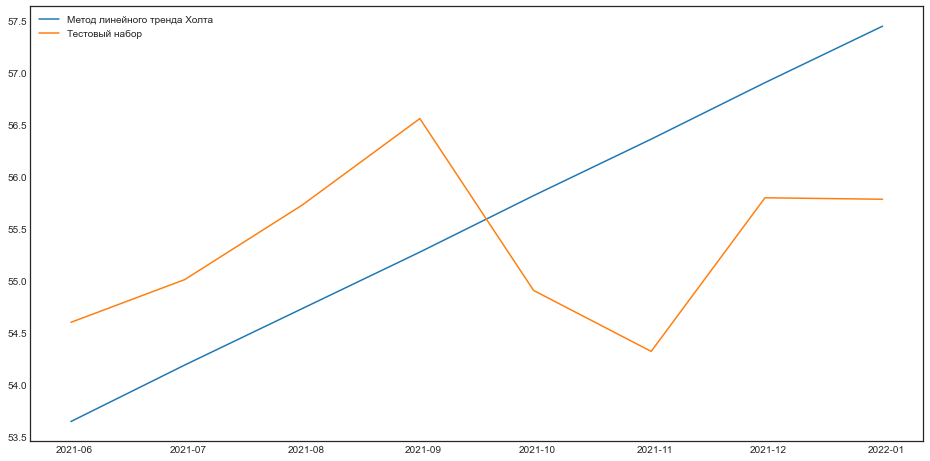

In [90]:
from statsmodels.tsa.api import  Holt, ExponentialSmoothing

fit1 = Holt(train_2).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast1 = fit1.forecast(8)

mse_value = mean_squared_error(test_2, fcast1)
rmse_value = rmse(test_2, fcast1)
mape_value = np.mean(np.abs(fcast1 - test_2)/test_l)*100
mae_value = mean_absolute_error(test_2, fcast1)
print('Test MSE: %.3f' % mse_value)
print('Test RMSE: %.3f' % rmse_value)
print('Test MAPE: %.3f' % mape_value)
print('Test MAE: %.3f' % mae_value)

plt.figure(figsize=(16,8))
plt.plot(fcast1, label='Метод линейного тренда Холта')
plt.plot(test_2, label='Тестовый набор')

plt.legend()
plt.show()

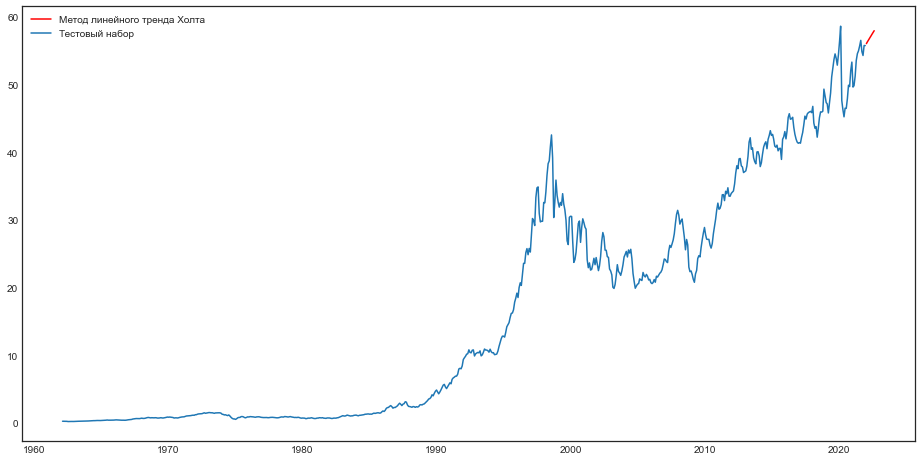

In [98]:
fit1 = Holt(df_ar).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast1 = fit1.forecast(8)

plt.figure(figsize=(16,8))
plt.plot(fcast1, label='Метод линейного тренда Холта', color ='r')
plt.plot(df_ar, label='Тестовый набор')

plt.legend()
plt.show()

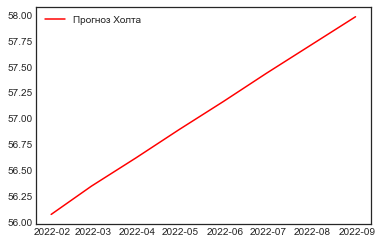

In [97]:
plt.plot(fcast1, color='r', label = 'Прогноз Холта')
plt.legend()
plt.show()

Test MSE: 2.237
Test RMSE: 1.496
Test MAPE: 2.272
Test MAE: 1.263


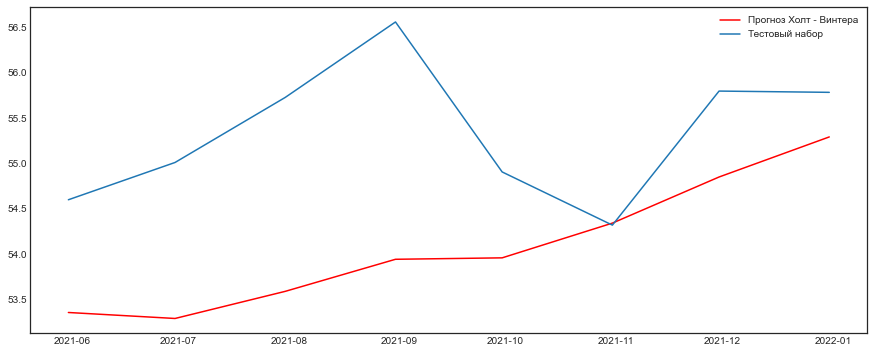

In [100]:
fit1 = ExponentialSmoothing(train_2, seasonal_periods=8,
                    trend='add', seasonal='add').fit(use_boxcox=True)
plt.figure(figsize =(15,6))

fcast2 = fit1.forecast(8)

mse_value = mean_squared_error(test_2, fcast2)
rmse_value = rmse(test_2, fcast2)
mape_value = np.mean(np.abs(fcast2 - test_2)/test_l)*100
mae_value = mean_absolute_error(test_2, fcast2)
print('Test MSE: %.3f' % mse_value)
print('Test RMSE: %.3f' % rmse_value)
print('Test MAPE: %.3f' % mape_value)
print('Test MAE: %.3f' % mae_value)

plt.plot(fcast2, color='r', label = 'Прогноз Холт - Винтера')
plt.plot(test_2, label='Тестовый набор')
plt.legend()
plt.show()

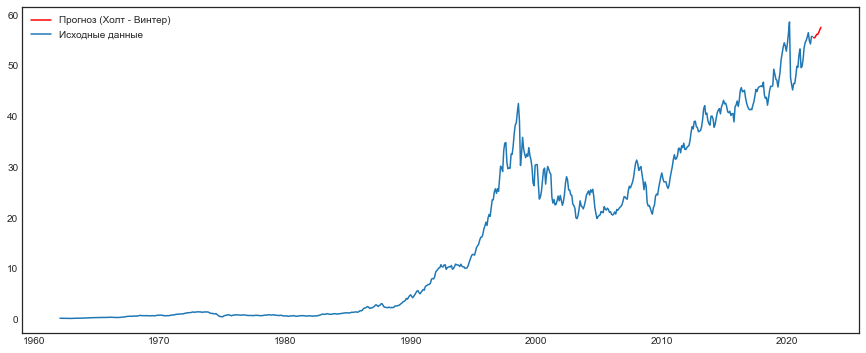

In [95]:
fit1 = ExponentialSmoothing(df_ar, seasonal_periods=8,
                    trend='add', seasonal='add').fit(use_boxcox=True)
fcast2 = fit1.forecast(8)
plt.figure(figsize =(15,6))

plt.plot(fcast2, color='r', label = 'Прогноз (Холт - Винтер)')
plt.plot(df_ar, label='Исходные данные')
plt.legend()
plt.show()

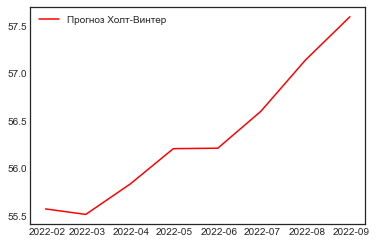

In [96]:
plt.plot(fcast2, color='r', label = 'Прогноз Холт-Винтер')
plt.legend()
plt.show()

In [ ]:
# Сравнение точности моделей на тестовом наборе
# модель AR
#Test MSE: 1.681
#Test RMSE: 1.297
#Test MAPE: 1.902
#Test MAE: 1.058
# модель SARIMA  
#MSE Error: 1.804042525
#RMSE Error: 1.343146502
#MAPE Error:   2.1533203
#MAE Error: 1.196008151
# метод линейного тренда Холта
#Test MSE: 1.648
#Test RMSE: 1.284
#Test MAPE: 2.208
#Test MAE: 1.221
# метод Холта-Винтера
#Test MSE: 2.237
#Test RMSE: 1.496
#Test MAPE: 2.272
#Test MAE: 1.263